# Heatmaps nb de modèles simulant la neige (à partir Snowmass as Brutel-Vuilmet et al)

In [1]:
from watermark import watermark
%load_ext watermark
print(watermark())

Last updated: 2025-06-06T13:18:54.356566+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
from skimage.measure import find_contours
import os
import calendar
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl

In [3]:
%watermark --iversions

pandas    : 2.2.3
cartopy   : 0.24.0
numpy     : 2.0.2
watermark : 2.5.0
matplotlib: 3.10.0
xarray    : 2025.1.1
skimage   : 0.25.0



In [4]:
def get_data(path_snw, path_areacella, path_sftlf):
    ds_snw = xr.open_dataset(path_snw)
    ds_area = xr.open_dataset(path_areacella)
    ds_sftlf = xr.open_dataset(path_sftlf)
    return ds_snw, ds_area, ds_sftlf

def extraction_variable_and_monthly_mean(ds_snw, variable="snw", start_year="1995", end_year="2014", lat_min=20):
    snw = ds_snw[variable].sel(time=slice(start_year, end_year))

    if lat_min is not None:
        snw = snw.sel(lat=snw.lat >= lat_min)

    #snw = snw.where(snc < 1e19, float("nan"))

    #max_val = snw.max().item()
    #if max_val > 1.5:
        #print(f"La variable '{variable}' est en %. Conversion en fraction.")
        #snw = snw / 100

    if sftlf is not None:
        snw=snw.where(sftlf>0)

    #snw = snw.clip(0, 1)

    snowmass = snw.groupby("time.month").mean(dim="time")
    monthly_mean = snowmass.mean(dim=("lat", "lon"))

    return snw, snowmass, monthly_mean

def binary_mask_from_snw(snowmass, threshold=5):
    mask = xr.where(snowmass > threshold, 1, 0)
    return mask

def snow_surface_calculation(snowmass, areacella):
    area_km2 = areacella * 1e-6
    snow_cover_km2 = (snow_cover * area_km2).groupby(snow_cover["month"]).sum(dim=["lat", "lon"], skipna=True)
    return snow_cover_km2

def plot_snow_cover_initial(snc, time_index=0, title="Carte couverture neigeuse", ax=None):
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.axes(projection=ccrs.PlateCarree())
        show_plot = True
    else:
        show_plot = False
        
    snc.isel(time=time_index).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.coastlines()
    ax.set_title(title)

    if show_plot:
        plt.show

def plot_binary_mask(binary_mask, month=1, title="Carte couverture neigeuse", ax=None):
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.axes(projection=ccrs.PlateCarree())
        show_plot = True
    else:
        show_plot = False
        
    binary_mask.isel(month=month).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.coastlines()
    ax.set_title(title)

    if show_plot:
        plt.show

def plot_monthly_mean(monthly_mean, xlabel="Mois", ylabel="Average Snow Cover", title="Monthly average snow cover"):
    plt.plot(range(1, 13), monthly_mean, marker="o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

def plot_surface_km2(snow_cover_km2, xlabel="Mois", ylabel="Snowy surface (km2)", title="Average monthly snow cover area"):
    plt.plot(range(1, 13), snow_cover_km2, marker="o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

In [5]:
files = os.listdir("/home/jovyan/private-storage/output_data/interp_snowmass/")

nc_files = [filename for filename in files if filename.endswith(".nc")]
nc_files

['CanESM5_snowmass_reprojete.nc',
 'CESM2_snowmass_reprojete.nc',
 'BCC-CSM2-MR_snowmass_reprojete.nc',
 'CIESM_snowmass_reprojete.nc',
 'CanESM5-CanOE_snowmass_reprojete.nc',
 'CESM2-WACCM_snowmass_reprojete.nc',
 'CNRM-CM6-1_snowmass_reprojete.nc',
 'CNRM-CM6-1-HR_snowmass_reprojete.nc',
 'CNRM-ESM2-1_snowmass_reprojete.nc',
 'EC-Earth3_snowmass_reprojete.nc',
 'EC-Earth3-Veg_snowmass_reprojete.nc',
 'GFDL-CM4_snowmass_reprojete.nc',
 'GISS-E2-1-G_snowmass_reprojete.nc',
 'HadGEM3-GC31-LL_snowmass_reprojete.nc',
 'IPSL-CM6A-LR_snowmass_reprojete.nc',
 'MIROC-ES2L_snowmass_reprojete.nc',
 'MIROC6_snowmass_reprojete.nc',
 'MPI-ESM1-2-HR_snowmass_reprojete.nc',
 'MPI-ESM1-2-LR_snowmass_reprojete.nc',
 'MRI-ESM2-0_snowmass_reprojete.nc',
 'NorESM2-LM_snowmass_reprojete.nc',
 'NorESM2-MM_snowmass_reprojete.nc',
 'UKESM1-0-LL_snowmass_reprojete.nc']

In [6]:
excluded_models = ["CIESM"]

filtered_nc_files = [f for f in nc_files if not any(model in f for model in excluded_models)]

/tmp/ipykernel_1902/1496245399.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


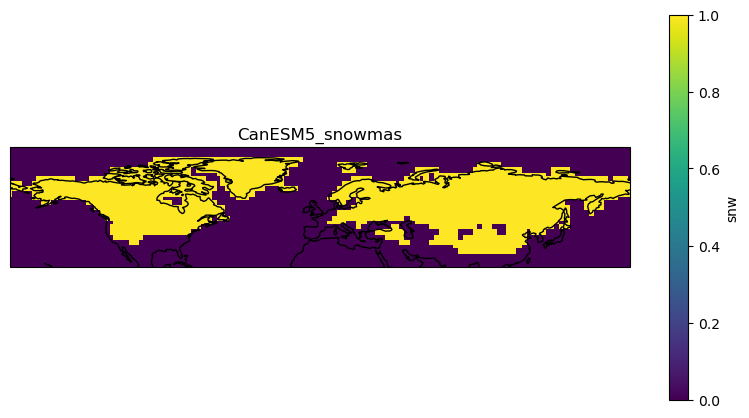

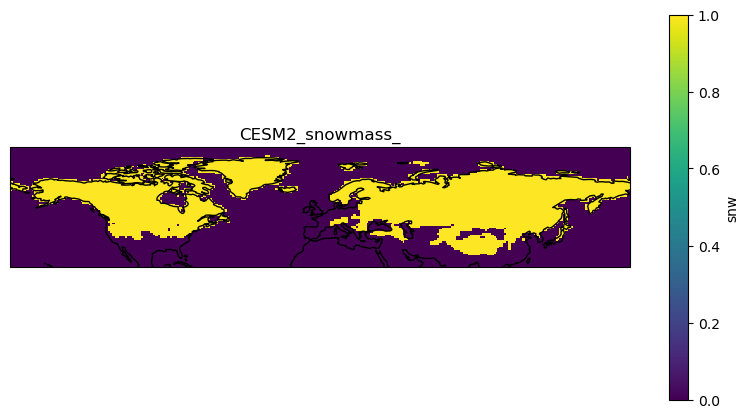

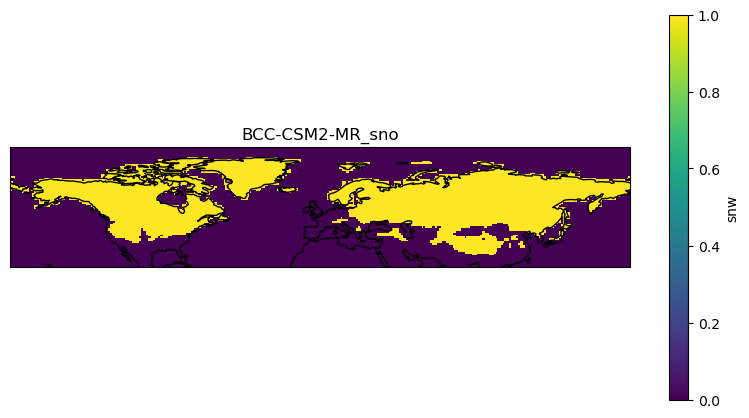

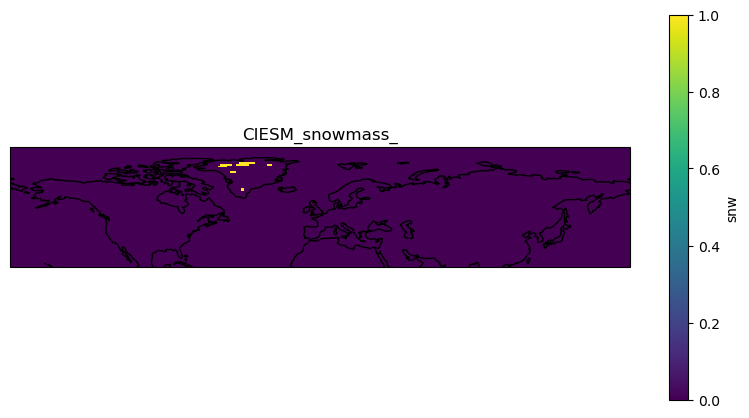

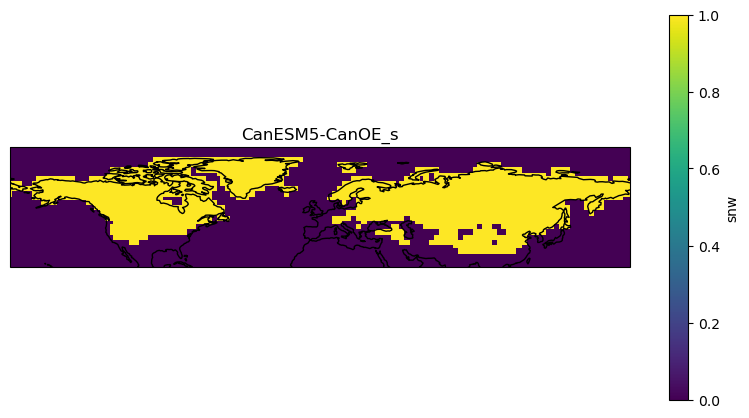

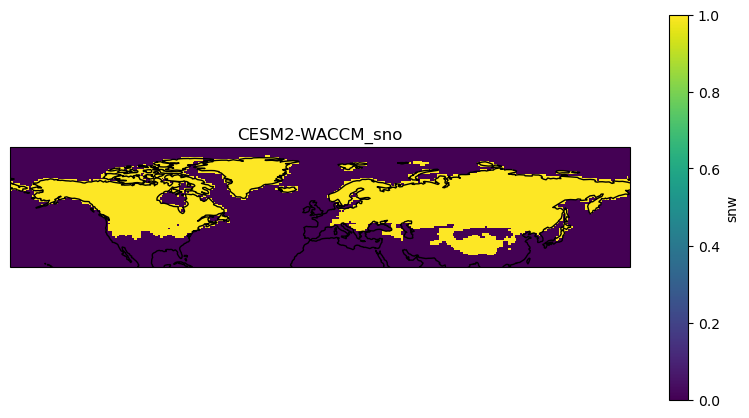

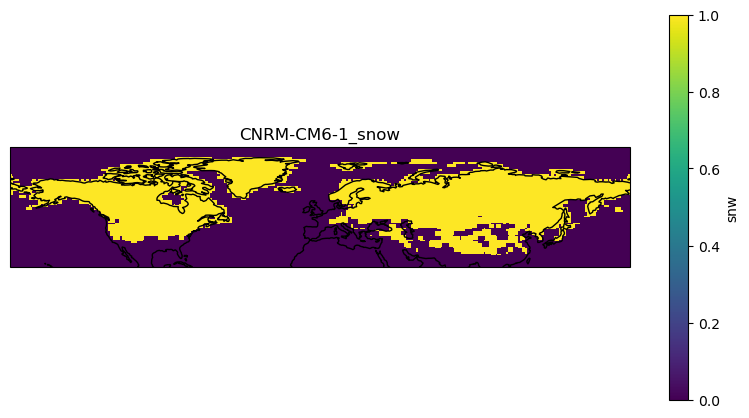

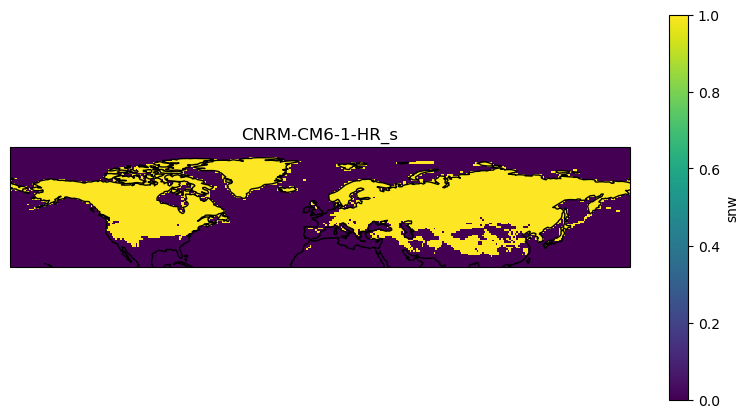

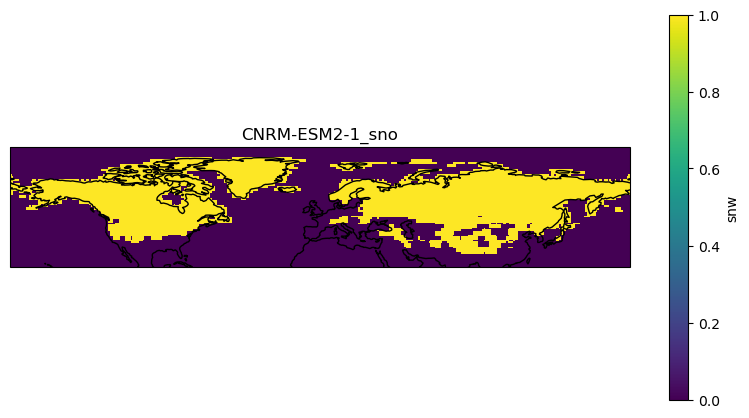

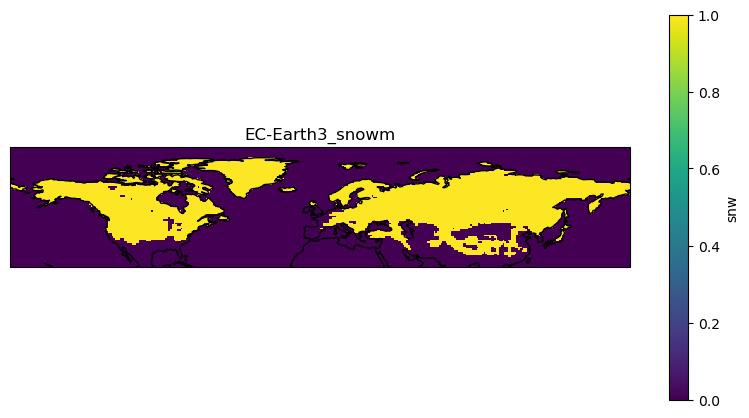

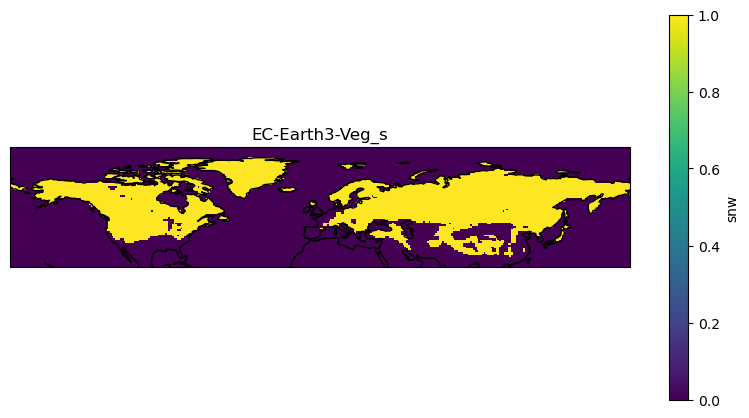

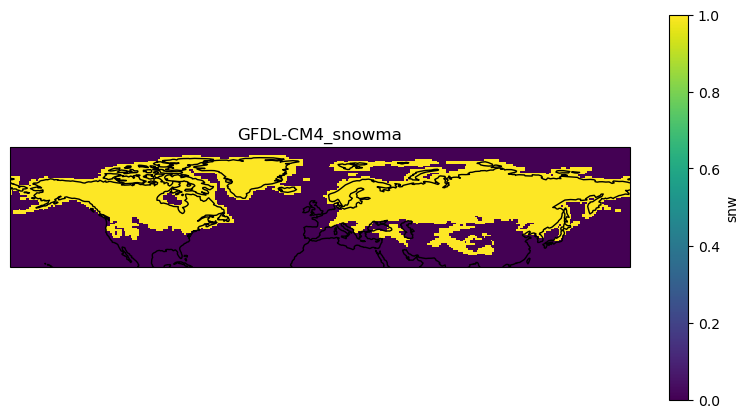

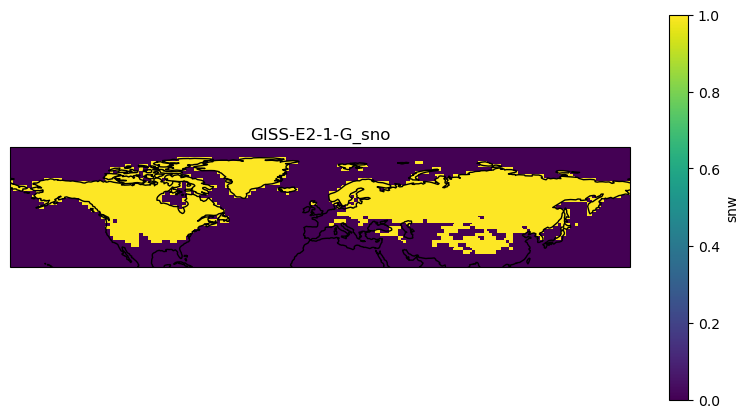

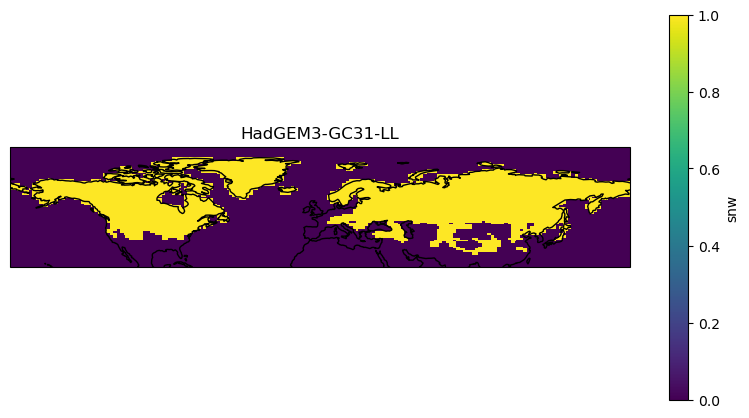

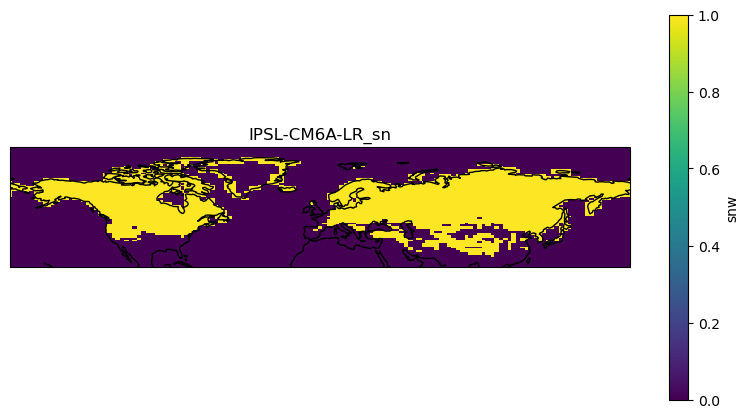

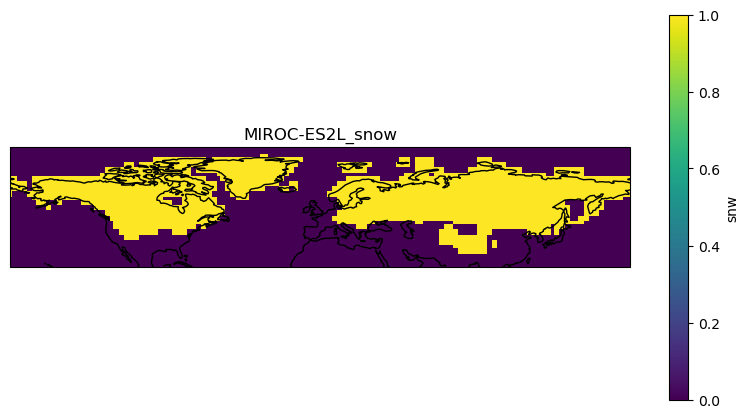

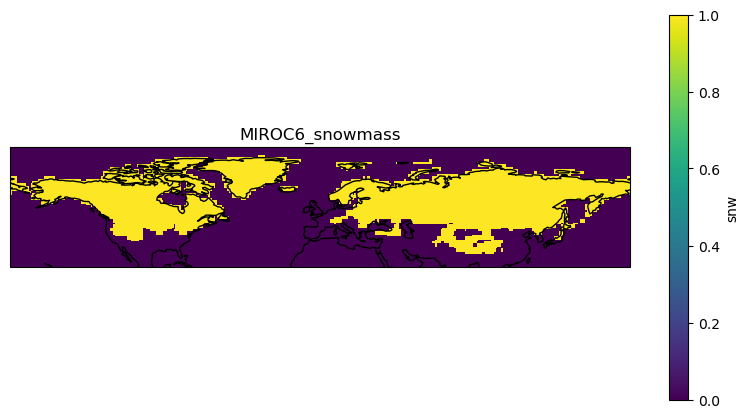

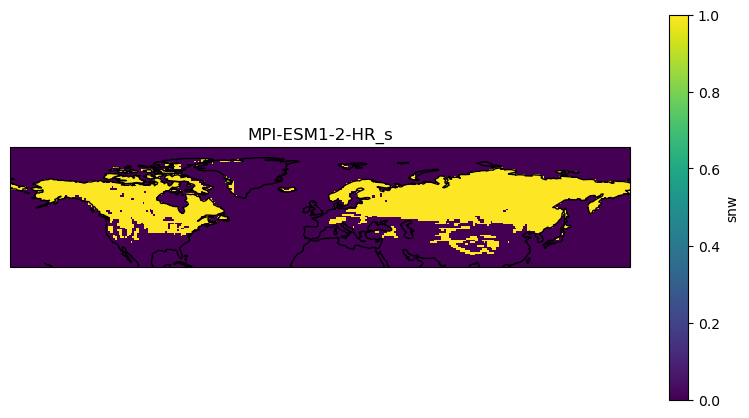

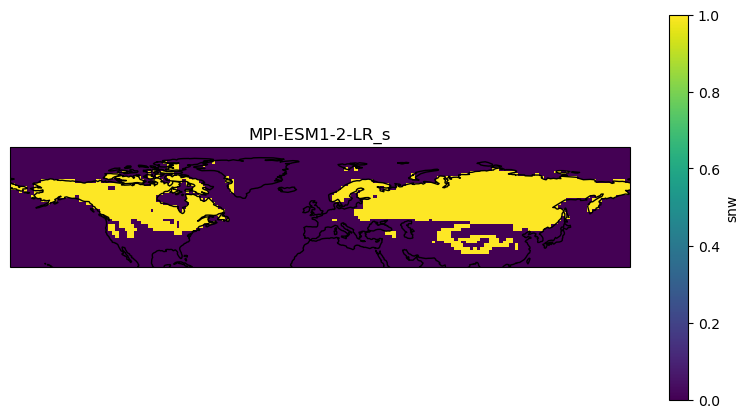

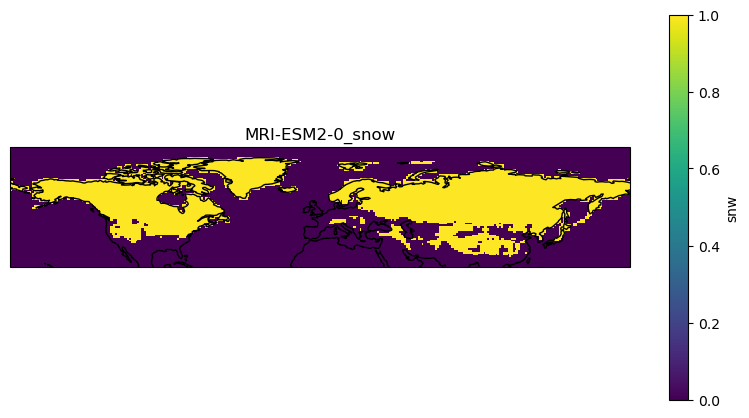

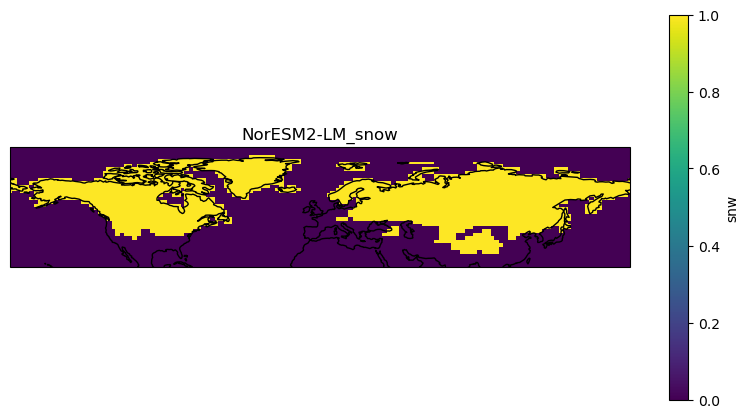

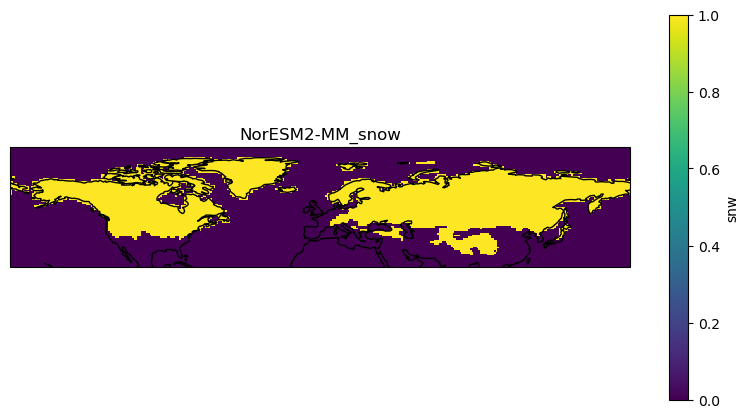

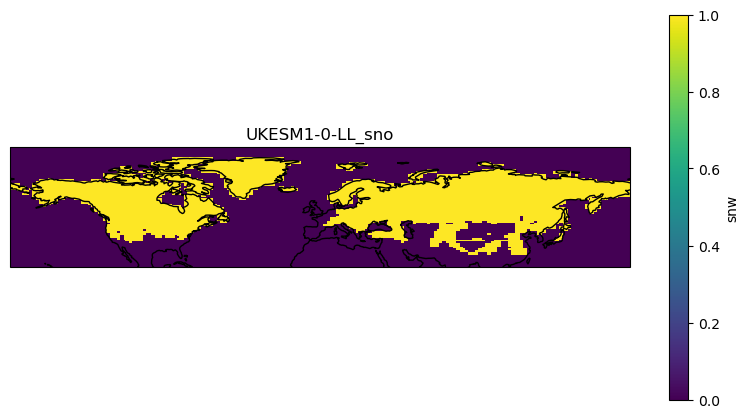

In [7]:
snowmass_dict = {}

for i, files in enumerate(nc_files):
    model_name = files.split("_")[0]
    
    path_snw = os.path.join("/home/jovyan/private-storage/output_data/interp_snowmass/", files)
    path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", files.replace("snowmass_reprojete", "gridarea_hist_recalcule"))
    path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", files.replace("snowmass", "sftlf"))
                                 
    ds_snw, ds_area, ds_sftlf = get_data(path_snw, path_areacella, path_sftlf)
    sftlf = ds_sftlf["sftlf"]
    snw, snowmass, monthly_mean = extraction_variable_and_monthly_mean(ds_snw)
    binary_mask = binary_mask_from_snw(snowmass)

    areacella = ds_area["cell_area"]
    #snow_cover_km2 = snow_surface_calculation(snow_cover, areacella)
    snowmass_dict[model_name] = binary_mask

    #ax = axes[i]
    plot_binary_mask(binary_mask, title=files[:15])

    #print(snow_cover_km2)
    
    ds_snw.close()
    ds_area.close()

In [8]:
for model, da in snowmass_dict.items():
    if 'type' in da.coords:
        print(f"{model}: {da['type'].values}")

CanESM5: b'land'
CNRM-CM6-1: b'typeland'
CNRM-CM6-1-HR: b'typeland'
CNRM-ESM2-1: b'typeland'
GISS-E2-1-G: b'land'
HadGEM3-GC31-LL: b'land'
IPSL-CM6A-LR: b'typeland'
MIROC-ES2L: b'land'
MIROC6: b'land'
MRI-ESM2-0: b'land'
UKESM1-0-LL: b'land'


In [9]:
cleaned_snw = []
model_names = []

for model, da in snowmass_dict.items():
    if 'type' in da.coords:
        da = da.drop_vars('type')

    cleaned_snw.append(da)
    model_names.append(model)

In [10]:
all_snw = xr.concat(cleaned_snw, dim=xr.DataArray(model_names, dims="model"))

monthly_sum = all_snw.sum(dim="model")

In [11]:
path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", "MRI-ESM2-0_sftlf_reprojete.nc")

sftlf = xr.open_dataset(path_sftlf)
sftlf = sftlf["sftlf"]

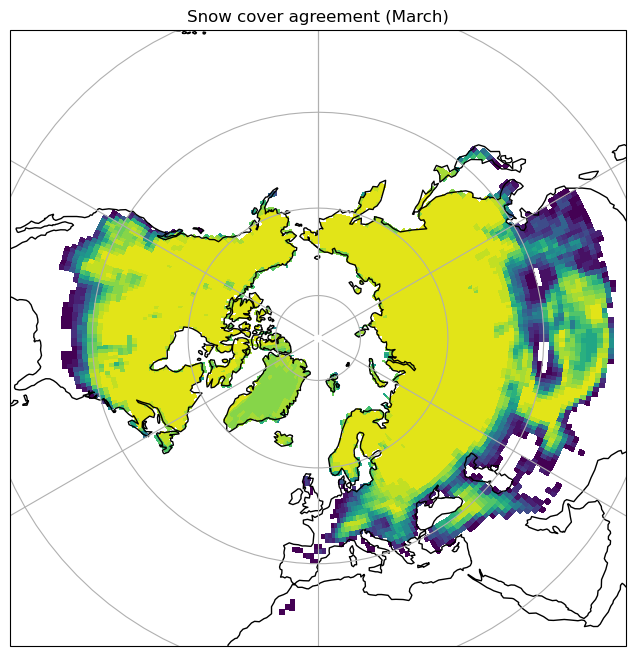

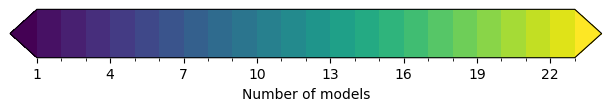

In [12]:
month_idx = 1  # mars
data = monthly_sum.isel(month=month_idx)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# choisir la bonne grille
landmask = sftlf > 50
data_plot = data.where((data > 0) & (landmask))

# plot
mesh = ax.pcolormesh(
    data_plot['lon'],
    data_plot['lat'],
    data_plot,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=1,
    vmax=23
)

ax.coastlines()
ax.gridlines(draw_labels=False)
ax.set_extent([-180, 180, 25, 90], ccrs.PlateCarree())

plt.title("Snow cover agreement (March)")

# couleurs
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.viridis
bounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Number of models")

#plt.tight_layout()
plt.show()

## Snow reference

In [13]:
path_snow_ref = os.path.join("~/private-storage/output_data/", "snow_reference.nc")
snow_ref = xr.open_dataset(path_snow_ref)
snow_ref = snow_ref["snow_cover_extent"]
snow_ref

<xarray.DataArray 'snow_cover_extent' (month: 12, lat: 180, lon: 360)> Size: 3MB
[777600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  surface_snow_binary_mask
    long_name:      NOAA/NCEI Climate Data Record of snow cover extent
    cell_methods:   time: mean
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered

In [14]:
path = "/home/jovyan/private-storage/grid/"
file = "area.nc"
area = xr.open_dataset(os.path.join(path, file))

In [15]:
# définition des saisons
season_months = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11]
}

In [16]:
seasonal_snow_reference = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = snow_ref.sel(month=months_float)
    seasonal_snow_reference[season] = da_sel.mean(dim="month", skipna=True)

In [17]:
djf_snow_reference = seasonal_snow_reference['DJF']
mam_snow_reference = seasonal_snow_reference['MAM']
jja_snow_reference = seasonal_snow_reference['JJA']
son_snow_reference = seasonal_snow_reference['SON']

## Cartes par saison 

In [18]:
seasonal_sum = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = monthly_sum.sel(month=months_float)
    seasonal_sum[season] = da_sel.mean(dim="month", skipna=True)

In [19]:
seasonal_sum_DJF = seasonal_sum['DJF']
seasonal_sum_MAM = seasonal_sum['MAM']
seasonal_sum_JJA = seasonal_sum['JJA']
seasonal_sum_SON = seasonal_sum['SON']

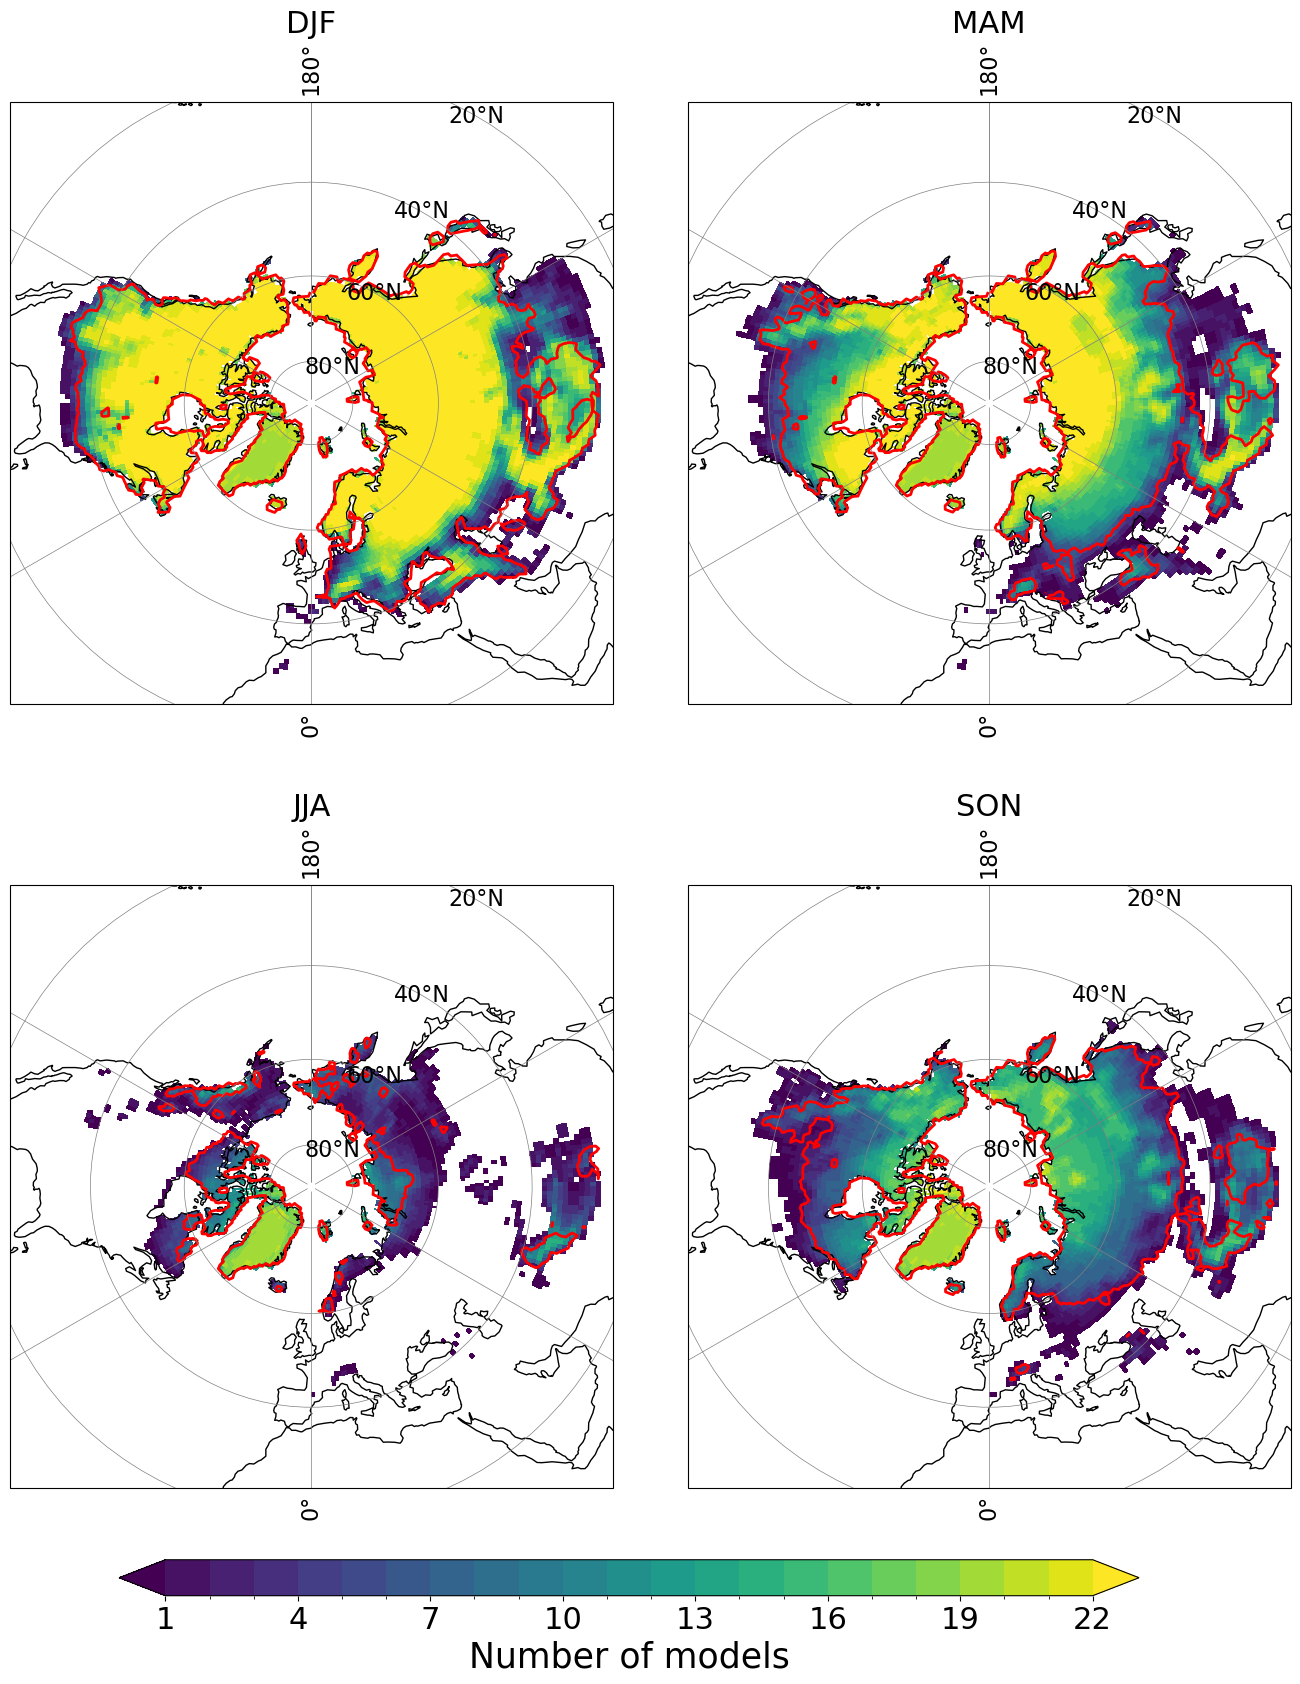

In [27]:
# Dictionnaires des valeurs par saison et référence
seasonal_data = {
    'DJF': seasonal_sum_DJF,
    'MAM': seasonal_sum_MAM,
    'JJA': seasonal_sum_JJA,
    'SON': seasonal_sum_SON
}

reference_data = {
    'DJF': djf_snow_reference,
    'MAM': mam_snow_reference,
    'JJA': jja_snow_reference,
    'SON': son_snow_reference
}

landmask = sftlf > 50

# figure
fig, axes = plt.subplots(2, 2, figsize=(17, 18), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

# couleurs
cmap = mpl.cm.viridis
bounds = list(range(1, 23))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

# tracé des 4 saisons
for ax, (season, data) in zip(axes, seasonal_data.items()):
    ref = reference_data[season]
    data_plot = data.where((data > 0) & (landmask))
    
    mesh = ax.pcolormesh(
        data_plot['lon'],
        data_plot['lat'],
        data_plot,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm
    )

    # contour de la référence
    contour = ax.contour(
        ref['lon'],
        ref['lat'],
        ref,
        levels=[0.15],  # seuil pour tracer le contour
        colors='red',
        linewidths=2,
        transform=ccrs.PlateCarree()
    )

    ax.set_title(f"{season}", fontsize=22)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, color='gray', linewidth=0.5, linestyle='-')
    gl.xlabel_style = {'size' : 16}
    gl.ylabel_style = {'size' : 16}
    ax.set_extent([-180, 180, 25, 90], ccrs.PlateCarree())

# Barre de couleur
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    orientation='horizontal'
)
cbar.set_label("Number of models", fontsize=25)
cbar.ax.tick_params(labelsize=22)

# Ajustement mise en page
plt.subplots_adjust(wspace=0.06, hspace=0.3)

#plt.savefig("snow_cover_agreement_snw.png")

plt.show()

## Création carte F

In [ ]:
F_all_models = []

for model_name, snow_sim in snowmass_dict.items():
    num = np.sum(np.minimum(snow_ref, snow_sim), axis=0)
    den = np.sum(np.maximum(snow_ref, snow_sim), axis=0)
    F = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=den != 0)
    F_all_models.append(F)

F_mean = np.mean(F_all_models, axis=0)

In [23]:
# Grille cible depuis un modèle
sample_model = list(snowmass_dict.values())[0]
target_lat = sample_model.lat
target_lon = sample_model.lon

# Interpolation bilinéaire sur la grille du modèle
snow_ref_interp = snow_ref.interp(lat=target_lat, lon=target_lon)

In [25]:
snow_ref_array = snow_ref_interp.values

F_all_models = []

for model_name, snow_sim in snowmass_dict.items():
    print(f"🔄 Traitement du modèle {model_name}")
    
    snow_sim_array = snow_sim.values

    num = np.sum(np.minimum(snow_ref_array, snow_sim_array), axis=0)
    den = np.sum(np.maximum(snow_ref_array, snow_sim_array), axis=0)
    
    F = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=den != 0)
    
    F_all_models.append(F)

# Moyenne multi-modèle
F_mean = np.mean(F_all_models, axis=0)

🔄 Traitement du modèle CanESM5
🔄 Traitement du modèle CESM2
🔄 Traitement du modèle BCC-CSM2-MR
🔄 Traitement du modèle CIESM
🔄 Traitement du modèle CanESM5-CanOE
🔄 Traitement du modèle CESM2-WACCM
🔄 Traitement du modèle CNRM-CM6-1
🔄 Traitement du modèle CNRM-CM6-1-HR
🔄 Traitement du modèle CNRM-ESM2-1
🔄 Traitement du modèle EC-Earth3
🔄 Traitement du modèle EC-Earth3-Veg
🔄 Traitement du modèle GFDL-CM4
🔄 Traitement du modèle GISS-E2-1-G
🔄 Traitement du modèle HadGEM3-GC31-LL
🔄 Traitement du modèle IPSL-CM6A-LR
🔄 Traitement du modèle MIROC-ES2L
🔄 Traitement du modèle MIROC6
🔄 Traitement du modèle MPI-ESM1-2-HR
🔄 Traitement du modèle MPI-ESM1-2-LR
🔄 Traitement du modèle MRI-ESM2-0
🔄 Traitement du modèle NorESM2-LM
🔄 Traitement du modèle NorESM2-MM
🔄 Traitement du modèle UKESM1-0-LL


In [32]:
# Palette
cmap = mpl.cm.magma

# Classes de performance : de 0 à 1 par pas de 0.05 ou 0.1
bounds = np.arange(0, 1.05, 0.05)  # 21 classes

# Norme associée pour map discrète
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N, extend='neither')

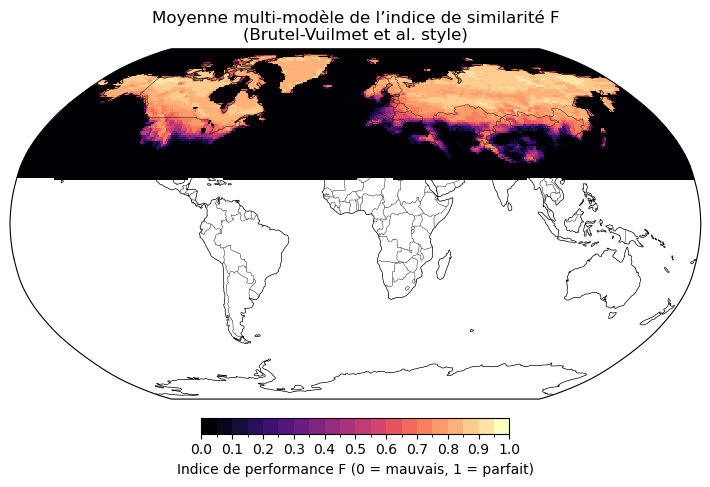

In [33]:
# Grille des modèles
lats = sample_model.lat.values
lons = sample_model.lon.values

# Création d’une figure
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())

# Ajout des continents, côtes, etc.
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.set_global()

# Grille à 2D pour pcolormesh
lon2d, lat2d = np.meshgrid(lons, lats)

# Affichage des scores F (0 à 1)
mesh = ax.pcolormesh(
    lon2d,
    lat2d,
    F_mean,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05, fraction=0.04)
cbar.set_label("Indice de performance F (0 = mauvais, 1 = parfait)")
cbar.set_ticks(bounds[::2])  # une tick sur deux

plt.title("Moyenne multi-modèle de l’indice de similarité F\n(Brutel-Vuilmet et al. style)")
plt.show()

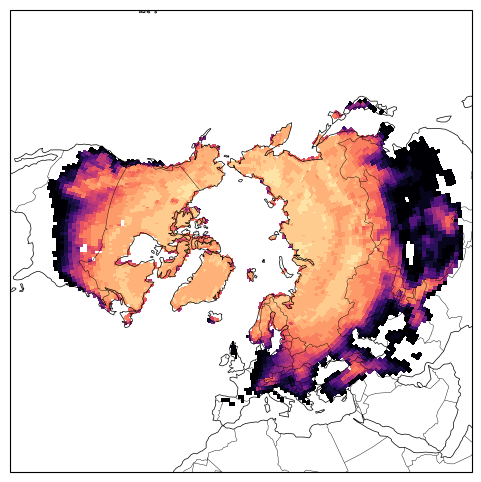

In [39]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())  # Limite à l'hémisphère nord

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Masque des zéros
masked_F = np.ma.masked_where(F_mean == 0, F_mean)

# Affichage
mesh = ax.pcolormesh(
    lon2d,
    lat2d,
    masked_F,
    cmap='magma',
    norm=norm,
    transform=ccrs.PlateCarree()
)

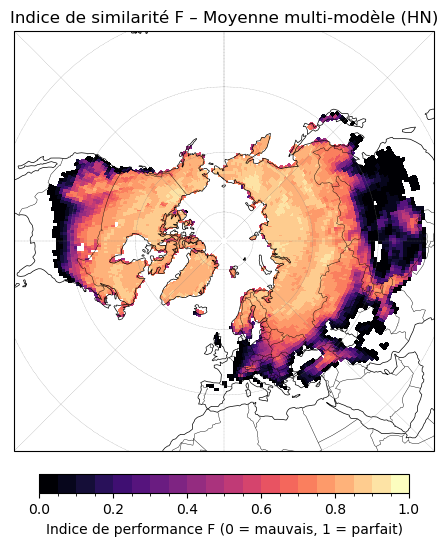

In [43]:
# Exemple de masque des valeurs nulles :
masked_F = np.ma.masked_where(F_mean == 0, F_mean)

# Création de la figure
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

# Zoom sur l'hémisphère nord
ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())

# Ajout des côtes et frontières
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Graticule (cercles de latitude et traits de longitude)
gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.2, color='gray')
gl.ylocator = plt.MultipleLocator(20) 
gl.xlocator = plt.MultipleLocator(45)

# Tracé des données
mesh = ax.pcolormesh(
    lon2d,
    lat2d,
    masked_F,
    cmap='magma',
    norm=norm,
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05, fraction=0.04)
cbar.set_label("Indice de performance F (0 = mauvais, 1 = parfait)")
cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, 6))  # Ajuster selon ton `norm`

# Titre
plt.title("Indice de similarité F – Moyenne multi-modèle (HN)", fontsize=12)

plt.show()


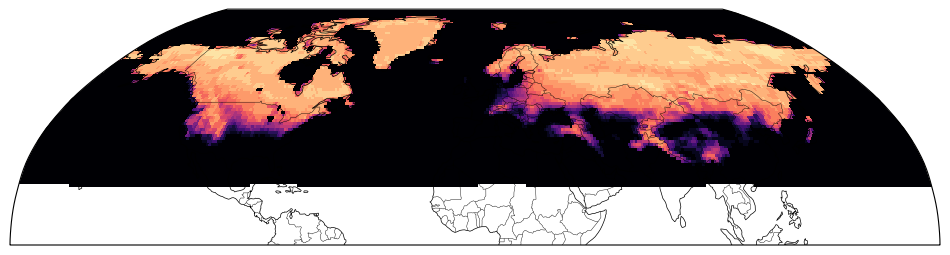

In [37]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())

ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())  # Zoom sur HN

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

mesh = ax.pcolormesh(
    lon2d,
    lat2d,
    F_mean,
    cmap='magma',
    norm=norm,
    transform=ccrs.PlateCarree()
)

In [22]:
print(snow_ref)

<xarray.DataArray 'snow_cover_extent' (month: 12, lat: 180, lon: 360)> Size: 3MB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  surface_